# Digit recognition with a CNN

Code to initiliaze Tensorflow 2.0 in Colab

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
#%tensorflow_version 2.x
import tensorflow as tf
#%load_ext tensorboard
import datetime
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt

**Import the MNIST dataset. The default loader will return tensors for the train/test partitions of the images and the labels.**

In [10]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,np.newaxis]/255.0   # our images are 4 dimensional (NumImages, Height, Width, Channels) - these images are grayscale so we only have 1 channel
x_test = x_test[:,:,:,np.newaxis]/255.0 

**[TODO] Check the size of the loaded tensors**

In [11]:
print(f'Dimension of X_train: {x_train.shape}') # 6000 images used as training set, each with size 28x28 and only one channel cause they are in greyscale
print(f'Dimension of X_test: {x_test.shape}') # 1000 images used as test set
print(f'Dimension of Y_train: {y_train.shape}') # 6000 labels
print(f'Dimension of Y_test: {y_test.shape}') # 1000 labels

Dimension of X_train: (60000, 28, 28, 1)
Dimension of X_test: (10000, 28, 28, 1)
Dimension of Y_train: (60000,)
Dimension of Y_test: (10000,)


**Prepare Keras callback for Tensorboard**

In [12]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# %tensorboard --logdir logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

**[TODO] Define a Keras Sequential model with the convolutional neural network**

In [13]:
# we are performing images classification, so given a dataset of labeled images (supervised learning) we want that our model understand how to extract features and then use these to predict the class of the image
# for the process of features extraction we use convolutional layers, that performs F different filters on the same image in order to obtain a map associated to each filter. These maps correspond to some features
# extracted from the images. These process of features extraction is called convolutional encoding, cause through the convolutional layers we are ectracting more and more details from the image and we are reducing
# the size of the image. In our case we use 'same' padding, this means that the on the input image are added new pixels in the border, so the convolution can return an image with the same size. This new pixels can
# be added equals to 0 (zero padding), or with the same values of the real borders (symmetric padding), or with the same values just over the border (reflection padding). We could decide to not perform any padding,
# so we give to the convolutional layer the original image, this method is called valid padding and the returned output will be the image reduced of 2 pixels on each dimension.
# While we are going deeper in the NN, the convolutional layers should extract more features cause we want to extract more and more complex features. Note that a pixel in the output image of convolutional layer is
# is evaluated on a perceptive field of the size of the kernel used by the convolution, so while we are going deeper each pixel contains the information of more pixels.
# Between the layers we are also performing Batch Normalization, this is important cause it normalize (by standardization) the input values by considering the statistics (mean and standard devietion) of a batch
# of the data. This is important cause it reduce the effect of too low value that could bring to vanishing gradient, and too high value that could bring to exploding gradient.
# The we use an activation function, that recives the input values and perform on them the ReLu activation function. The activation function perform an operation of the input. Is important that this function is
# non linear, cause if it was linear it will perform the same operations on each input, and so we loose the advantages of having multiple layers cause they are all performing the same action.
# We can decide between sigmoid, ReLu and Leaky ReLu for applying the non linear activation function. Sigmoid function is the worst, cause all the low input are forced to 0 and all the high input are forced to 1,
# this cause saturation of the outputs and so vanishing gradient. ReLu is a linear function (y=x) on positive inputs, but it force all the negative inputs to 0. Leaky ReLu is the same but it doesn't force
# the negative input to 0 but it set them with a linear function (y=x/10).
# Between the convolutional layers we are also performing Pooling, these operations reduces the dimension of the image (not of the features) by selecting a specific value (max, min, avarege) on the kernel.
# For applying the classification we use softmax function that returns a pdf between all the 10 possible classes. Before doing so, softmax function need a vector as input, so we have to flat the matrix into a
# vector by using Flatten layer. From the pdf of the softmax we read the class with the higher probability. This is how a convolutional encoder works for performing image classification.
# Before deciding the class i've added a new layer that perform dropout. This will remove randomly 50% of the neurons from the trained network and then try to train the other neurons to perform the same.
# This method reduces the dimension of the neural network but it increases the values of the parameters. Parameters increases of 1/(1-p), where p is the percentage of neurons freed. Having high values of the
# parameters could be not good, cause high weights made the model very sen sistive on input channges. So we could also perform regularization to give penalty on the cost function for high weights.
# I have tested that the model with the regularization perform worst than the model without it, so i decided to remove regularization.
# Another annotation is that instead of using the Flatten operation to prepare the input for the classification layer, we could use a GlobalAveragePooling2D layer that performs the mean
# value of each image feature map. This is useful cause the shape of the input of the classification layer doesn't depend anymore on the size of the original image, but only on the number of
# channels, so the classificator can work with images of different shapes.
# Note that the NN is divided into two steps, before it applies features extraction and then it performs decision making on those.
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01)),  # extracts basics features from the image by using a convolutional kernel (3x3) and 32 filters, so we get 32 feature maps. With the regularization the cost function receive a penalty that follows the square norm of the weights.
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(), # this layer normalize the output by applying standardization by using the statistics evaluated on a batch extracted from the training dataset. Used to avoid exploding and vanishing gradient
    tf.keras.layers.ReLU(), # non linear activation function. All the negative input are forced to 0, the positive ones are setted following a linear function y=x
    tf.keras.layers.MaxPooling2D((2,2)),    # halve the size of the image by taking the maximum value from a 2x2 square
    # tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # we increase the number of filters to 64, so we get 64 feature maps. This layer will extract more complex features
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),    # halve the size of the image by taking the maximum value from a 2x2 square
    # tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # we extract again more complex features
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),  # we flatten the 3D tensor to a 1D tensor, because Dense layer only accepts 1D tensor
    tf.keras.layers.Dropout(0.5),   # we use dropout to avoid overfitting, this layer randomly set 0 some neurons, then the NN is forced to train with the remeining ones how to work as previous
    tf.keras.layers.Dense(10, activation='softmax') # softmax activation function is used to get the probabilities of each class, so the output is a vector of 10 probabilities (one for each class) summed to 1
])

**[TODO] Compile the Keras model: specify the optimization algorithm, the loss function and the test metric**

In [14]:
# Train a NN means trying to find the best weights and biases (parameters of the NN) that can explain in the best way possible the relations between inputs and outputs. For doing so we must evaluate we amount 
# of error made by our model, so we can understand how far we are from the desired result. This evaluation is done through the cost function, that could be the MSE (mean square error) or the cross entropy 
# evaluated between the desired output and the one that our NN returns. After having evaluated the amount error through the cost function, we have to understand how to change the parameters in order to reduce the
# error. This could be done by evaluating the gradient, so we derive the cost function on each parameter and we obtain a vector in the space of the function that indicates to us the direction where we have to move
# for reducing the error. Our goal is to arrive to the minimum point of this function by exploiting the gradient, so we evaluate the cost function and then we update the parameters with the gradiet until we reach
# a convergence. This algorithm is called gradient descending, and it ensures that we could reach a local minimum point, but not that it is the global minimum. We could start from random parameters and see where
# the algorithm brings us. Then we can try again with other random parameter and see if the gradient descend converge on better minimum. This is the way how we can increase the prbability of reaching the global
# minimum. Note that the gradient gives us only the direction where we have to move, but not the amount of step that we should perform. For finding this value we should evaluate the second derivative, but this mean
# to evaluate (number of parameters)^2 derivative of the cost function, too complex in system with many parameters as the NN. So what we can do is to estimate the amount of step through a learning rate.
# A too big step can cause jumping over minimum point and so guide on the wrong direction the algorithm, instead a too short step could slow down the covergence of the algorithm.
# We know that the cost function after having applied the step should be lower that the actual value: C(w + Δw) - C(w) = -n ∇_w (C), where n is the learning rate.
# At each iteration gradient descending must read the entire dataset for evaluating the cost function and then update the parameters with the gradient. An optimization is the Stocastic Gradient Descending, that
# performs the same actions but it doesn't load the entire dataset but it extract from it a batch and then it doesn't put it back. So at each iteration the cost function is evaluated on the extracted batch, and
# the size of the training set decreases of the batch size. The number of epochs rappresent the number of times that the algorithm should see the entire training set, so the total number of iterations performed
# by this algorithm is (n / b) * e, where n is the size of the training set, b is the size of the batch and e is the number of epochs. 
# Adam oprimizer is an optmization of the stochastic gradient descent, that changes the learnig rate through the iterations by considering the statistics of the gradient.
lr = 0.01   # learning rate
model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

**[TODO] Train the Keras model**

In [15]:
model.fit(x_train, y_train, batch_size=128, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.8819 - loss: 0.4387
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.9781 - loss: 0.0665
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9835 - loss: 0.0529
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9854 - loss: 0.0467
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9856 - loss: 0.0427


**[TODO] Print model summary**

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        15,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,288 (407.38 KB)

 Trainable params: 34,698 (135.54 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 69,398 (271.09 KB)

**[TODO] Test the Keras model by computing the accuracy the whole test set**

In [17]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9900 - loss: 0.0302


[0.02569195255637169, 0.9915000200271606]

**[TODO] Visualize test image number 47 and the prediction from the neural network**

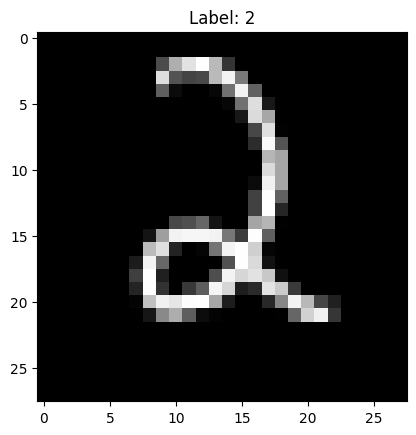

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predicted label: 2


In [18]:
plt.imshow(x_test[47].reshape(28, 28), cmap='gray')
plt.title(f'Label: {y_test[47]}')
plt.show()

y_pred = model.predict(x_test[47][np.newaxis, :, :, :])
print(f'Predicted label: {np.argmax(y_pred)}')